### The logistic model used in [Grubaugh2019](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-018-1618-7) combined AF (minor allele frequency) and StrandAF (strand bias). However, the calculation of StrandAF might incur an issue of collinearity between AF and StrandAF. This collinearity made StrandAF as a potentially good discriminator, which was suggested by the ROC curve of StrandAF in Fig. 5b in [Grubaugh2019](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-018-1618-7). 

To solve this issue, Sergei suggested using ForwardAF and ReverseAF, which is the goal of this notebook. 

This notebook takes three four files from [Grubaugh2019_reanalysis_MinION/start_from_trimmed.sorted.bam](https://github.com/hanmei5191/Grubaugh2019_reanalysis_MinION/tree/master/start_from_trimmed.sorted.bam). 

In [1]:
%load_ext rpy2.ipython

In [2]:
%%R 
library("tidyverse")
options(dplyr.width = Inf)
options(readr.num_columns = 0)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.2     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [3]:
%%R 
# Read in the three datasets "BC01.variants.0.03.txt", "BC02.variants.0.03.txt", "BC03.variants.0.03.txt". 
barcode1snps=read_tsv("BC01_modified.variants.0.03.txt")
barcode1snps$replica = 'a'

barcode2snps=read_tsv("BC02_modified.variants.0.03.txt")
barcode2snps$replica = 'b'

barcode3snps=read_tsv("BC03_modified.variants.0.03.txt")
barcode3snps$replica = 'c'

In [4]:
%%R
# Merge the three datasets
minion_variants=rbind(barcode1snps, barcode2snps, barcode3snps)

In [5]:
%%R 
expectedpositions=read_tsv("expectedpositions.txt")

In [6]:
%%R 
# Remove positions with the label "REMOVE"
minion_variants_positions=minion_variants %>%
   left_join(expectedpositions, by=c("Pos" = "Position")) %>%
   filter(State != 'Remove')

In [7]:
%%R
# Add strand bias info
# Note that here we do not filter out position 
# with (ForwardRefCov or ForwardVariantCov or ReverseRefCov or ReverseVariantCov < 10)
# Instead, we filter out rows with NaN in SB or GATK_SB or Fisher_SB. 

minion_variants_positions %>%
  mutate(Decision = ifelse(grepl("TRUE", State), 1, 0)) %>%
  mutate(ForwardAF = ForwardVariantCov / (ForwardRefCov + ForwardVariantCov)) %>% # (b/(a+b))
  mutate(ReverseAF = ReverseVariantCov / (ReverseRefCov + ReverseVariantCov)) %>% # (d/(c+d))
  filter(!is.na(ForwardAF)) %>%
  filter(!is.na(ReverseAF)) %>%
  write_tsv("minion_variants_positions_ForwardAF_ReverseAF.tsv")

In [8]:
import numpy as np 
import pandas as pd 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from itertools import cycle

In [9]:
data = pd.read_csv("minion_variants_positions_ForwardAF_ReverseAF.tsv", sep="\t")
data

,Pos,Qual,Freq,Ref,Base,UngappedCoverage,TotalCoverage,VariantCov,ForwardVariantCov,ReverseVariantCov,RefCov,ForwardRefCov,ReverseRefCov,replica,State,Decision,ForwardAF,ReverseAF
0,1070,0,0.091876,C,T,1034,1035,95,49,46,938,558,380,a,True,1,0.080725,0.107981
1,1129,0,0.038532,G,A,545,548,21,19,2,522,134,388,a,False,0,0.124183,0.005128
2,1175,0,0.247379,A,G,477,515,118,105,13,359,55,304,a,True,1,0.656250,0.041009
3,1176,0,0.043544,G,A,666,668,29,29,0,637,178,459,a,False,0,0.140097,0.000000
4,1183,0,0.031088,C,T,386,390,12,4,8,366,365,1,a,False,0,0.010840,0.888889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,10342,0,0.030395,A,T,329,333,10,10,0,317,223,94,c,False,0,0.042918,0.000000
431,10349,0,0.131959,T,C,485,487,64,36,28,419,152,267,c,True,1,0.191489,0.094915
432,10360,0,0.059671,C,T,486,487,29,1,28,457,277,180,c,False,0,0.003597,0.134615
433,10361,0,0.121348,T,C,445,465,54,26,28,391,249,142,c,True,1,0.094545,0.164706


In [10]:
def plot_LR_SVM_ROC(data): 
    alpha = np.logspace(-3, 5, 100)
    x = data[['ForwardAF', 'ReverseAF']]
    y = data['Decision']
    Freq = data['Freq']
    ForwardAF = data['ForwardAF']
    ReverseAF = data['ReverseAF']
    colors = cycle('mc')
    plt.figure(figsize=(7, 6), facecolor='w')
    models = [['LogisticRegression', LogisticRegressionCV(Cs=alpha, penalty='l2', cv=5)],
              ['SVM(Linear)', GridSearchCV(SVC(kernel='linear', decision_function_shape='ovo'), param_grid={'C': alpha}, cv=5)]]
    for (name, model), color in zip(models, colors):
        model.fit(x, y)
        if hasattr(model, 'predict_proba'):
            y_score = model.predict_proba(x)[:,1]
        else:
            y_score = model.decision_function(x)
        fpr, tpr, thresholds = metrics.roc_curve(y, y_score)
        auc = metrics.auc(fpr, tpr)
        plt.plot(fpr, tpr, c=color, lw=2, alpha=0.7, label="{0}, AUC={1:.3f}".format(name, auc))
    
    fpr, tpr, thresholds = metrics.roc_curve(y, Freq)
    auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, c='b', lw=2, alpha=0.7, label="{0}, AUC={1:.3f}".format("Frequency", auc))
    
    fpr, tpr, thresholds = metrics.roc_curve(y, ForwardAF)
    auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, c='y', lw=2, alpha=0.7, label="{0}, AUC={1:.3f}".format("ForwardAF", auc))
    
    fpr, tpr, thresholds = metrics.roc_curve(y, ReverseAF)
    auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, c='g', lw=2, alpha=0.7, label="{0}, AUC={1:.3f}".format("ReverseAF", auc))
    
    
    plt.plot((0, 1), (0, 1), c='#808080', lw=2, ls='--', alpha=0.7)
    plt.xlim((-0.01, 1.02))
    plt.ylim((-0.01, 1.02))
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.xlabel('False Positive Rate', fontsize=13)
    plt.ylabel('True Positive Rate', fontsize=13)
    plt.grid(b=True, ls=':')
    plt.legend(loc='lower right', fancybox=True, framealpha=0.8, edgecolor='#303030', fontsize=12)
    plt.title("ROC ForwardAF ReverseAF", fontsize=16)
    plt.savefig("ROC_ForwardAF_ReverseAF.pdf", format="pdf")

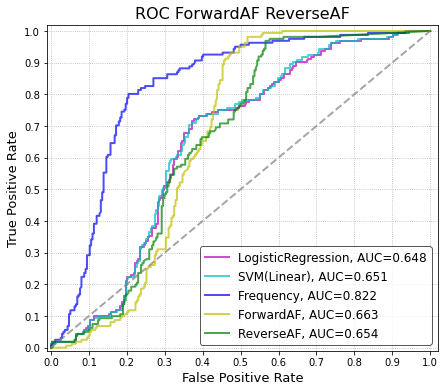

In [11]:
plot_LR_SVM_ROC(data)